In [ ]:
# Предсказание курса акций VipShop

# Данные возьмем из доступных ресурсов
# Для сравния результатов моделирования выберем метрику RMSE
# Попробуем сделать предсказание курса акции за последние 30 дней

#Парсинг данных

In [ ]:
# Парсинг данных

#!pip install yfinance

#import yfinance as yf
#data = yf.download('VIPS','2012-10-31','2021-11-26')
#print(data.tail(10))

# Сохраним данные на диск для удобства, в дальнейшем будем загружать их оттуда:

#data.to_csv('VIPS.csv')
#!cp VIPS.csv "/content/drive/MyDrive/Stock_price_pred/"

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [ ]:
#Загрузим необходимые для работы библиотеки:
import math
import numpy
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')

In [ ]:
# Загрузим наши данные:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Stock_price_pred/'
df = pd.read_csv(DATA_DIR+'VIPS.csv')

#EDA

In [ ]:
# Ознакомимся с датасетом
df.tail(30)

,Date,Open,High,Low,Close,Adj Close,Volume
2254,2021-10-14,11.51,11.58,11.16,11.32,11.32,6237000
2255,2021-10-15,11.46,11.92,11.23,11.47,11.47,9456500
2256,2021-10-18,11.43,11.67,11.28,11.45,11.45,4852300
2257,2021-10-19,11.68,12.49,11.62,12.42,12.42,11446200
2258,2021-10-20,12.60,13.32,12.46,12.50,12.50,13220600
2259,2021-10-21,12.45,12.95,12.42,12.78,12.78,5696400
2260,2021-10-22,12.73,13.00,12.36,12.46,12.46,5531400
2261,2021-10-25,12.55,12.70,12.00,12.46,12.46,5802400
2262,2021-10-26,12.51,12.51,11.62,11.88,11.88,9228000
2263,2021-10-27,11.71,12.15,11.55,11.68,11.68,6904600


In [ ]:
# Для моделирования будем использовать колонку Close нас будет интересовать цена акций на момент закрытия биржи

In [ ]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.Close.describe()

count    2284.000000
mean       13.950809
std         7.373549
min         1.003000
25%         8.420000
50%        13.195000
75%        18.142499
max        45.580002
Name: Close, dtype: float64

In [ ]:
df1 = df.reset_index()['Close']

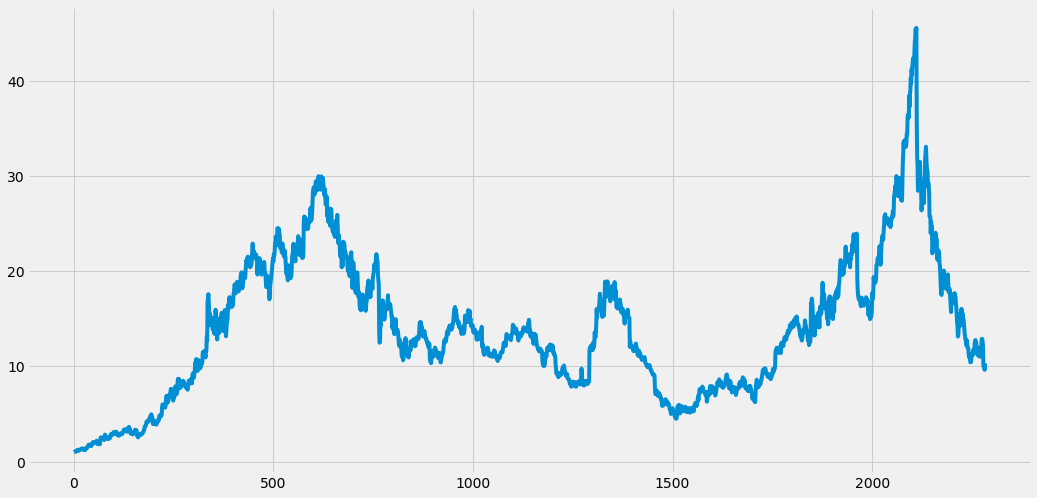

In [ ]:
# Построим график как изменялясь цена акции по дням
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
df1.plot()

In [ ]:
# Разделим данные на трейн, и отделим данные для предсказания за последние 30 дней

df2 = df1[:len(df1)-30]

In [ ]:
df2

0        1.003
1        1.025
2        1.025
3        1.013
4        1.025
         ...  
2249    11.020
2250    11.300
2251    11.180
2252    11.240
2253    11.700
Name: Close, Length: 2254, dtype: float64

In [ ]:
df2 = np.array(df2).reshape(-1,1)

In [ ]:
# Нормализуем данные с помощью MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(df2)

In [ ]:
# Делим оставшиеся данные на трейн и валидацию в пропорции 0.65/0.35

training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size
train_data,test_data=df2[0:training_size],df2[training_size:len(df2)]

In [ ]:
training_size,test_size

(1465, 789)

Для построения моделей применим следующую логику
Введем понятие time_step - это будет шаг нашей целевой переменной для алгоритма. Допустим time_step=3, тогда фичи -это первые три значения цены акции, а 4-е значение будет целевой переменной. Далее сдвигаемся на один шаг. df2[2],df2[3],df2[4], это следующие значения наших фичей, а df2(5) - это следующее значение нашей целевой переменной. То есть наша целевая переменная это результат 3-х предыдущих дней.
В решении буду использовать time_step=100, то есть уелевая переменная будет зависеть от предыдущих 100 дней. Напишем функцию для реализации данной логики 

In [ ]:
# Функция конвертирует наш массив данных в матрицу со столбцами фичей и столбцом целевой переменной
def create_dataset(dataset,time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0] ###i=0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX),numpy.array(dataY)

In [ ]:
# Построим датасет X=t,t+1,t+2,t+3.... and Y=t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

Посмотрим какие размерности получились

In [ ]:
print(X_train)

[[0.00000000e+00 4.93527027e-04 4.93527027e-04 ... 4.16806866e-02
  4.15909553e-02 4.44399548e-02]
 [4.93527027e-04 4.93527027e-04 2.24330710e-04 ... 4.15909553e-02
  4.44399548e-02 4.73113911e-02]
 [4.93527027e-04 2.24330710e-04 4.93527027e-04 ... 4.44399548e-02
  4.73113911e-02 4.56289081e-02]
 ...
 [3.50337622e-01 3.39569705e-01 3.38223732e-01 ... 1.37896221e-01
  1.37896221e-01 1.45747801e-01]
 [3.39569705e-01 3.38223732e-01 3.47196960e-01 ... 1.37896221e-01
  1.45747801e-01 1.41485512e-01]
 [3.38223732e-01 3.47196960e-01 3.46299659e-01 ... 1.45747801e-01
  1.41485512e-01 1.41261187e-01]]


In [ ]:
print(y_train)

[0.04731139 0.04562891 0.04446239 ... 0.14148551 0.14126119 0.13453125]


In [ ]:
print(X_train.shape), print(y_train.shape)

(1364, 100)
(1364,)


(None, None)

#Моделирование

#Модель LSTM

In [ ]:
df2.shape

(2254, 1)

In [ ]:
df2

array([[0.        ],
       [0.00049353],
       [0.00049353],
       ...,
       [0.22830159],
       [0.22964756],
       [0.23996678]])

In [ ]:
# Cнабдим еще одной размерностью 
# для нейросети LSTM [samples,timesteps,features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from  tensorflow.keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer = 'adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=10,batch_size=64,verbose=1 )

Epoch 1/10
22/22 [==============================] - 10s 243ms/step - loss: 0.0126 - val_loss: 0.0058
Epoch 2/10
22/22 [==============================] - 4s 184ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 3/10
22/22 [==============================] - 4s 184ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/10
22/22 [==============================] - 4s 180ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 5/10
22/22 [==============================] - 4s 184ms/step - loss: 9.5912e-04 - val_loss: 0.0029
Epoch 6/10
22/22 [==============================] - 4s 182ms/step - loss: 9.2766e-04 - val_loss: 0.0027
Epoch 7/10
22/22 [==============================] - 4s 183ms/step - loss: 8.9346e-04 - val_loss: 0.0026
Epoch 8/10
22/22 [==============================] - 4s 179ms/step - loss: 8.3623e-04 - val_loss: 0.0025
Epoch 9/10
22/22 [==============================] - 4s 181ms/step - loss: 8.2116e-04 - val_loss: 0.0023
Epoch 10/10
22/22 [==============================] - 4s 185ms/step - loss: 7.89

In [ ]:
# Сделаем предсказание на трейне и на тесте
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
test_predict

array([[0.11917212],
       [0.12078024],
       [0.12260787],
       [0.12468636],
       [0.12709421],
       [0.12975259],
       [0.1325514 ],
       [0.1354439 ],
       [0.1384023 ],
       [0.14136077],
       [0.1442385 ],
       [0.14703918],
       [0.14970374],
       [0.15211685],
       [0.15419434],
       [0.15590507],
       [0.15723239],
       [0.1581393 ],
       [0.15861341],
       [0.15866607],
       [0.15833078],
       [0.1577569 ],
       [0.15680373],
       [0.15552765],
       [0.15404342],
       [0.1525427 ],
       [0.15117265],
       [0.14999641],
       [0.14900655],
       [0.14828053],
       [0.14797895],
       [0.14809623],
       [0.14855719],
       [0.1491937 ],
       [0.1500394 ],
       [0.15110315],
       [0.15234615],
       [0.15365173],
       [0.15498014],
       [0.1562761 ],
       [0.15746303],
       [0.15843576],
       [0.15915324],
       [0.159498  ],
       [0.15948041],
       [0.15917236],
       [0.15874092],
       [0.158

In [ ]:
# Вернемся к начальной размерности данных
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
test_predict

array([[ 6.3153358],
       [ 6.3870206],
       [ 6.4684916],
       [ 6.5611444],
       [ 6.668479 ],
       [ 6.7869816],
       [ 6.911744 ],
       [ 7.040683 ],
       [ 7.1725597],
       [ 7.3044395],
       [ 7.43272  ],
       [ 7.5575657],
       [ 7.676344 ],
       [ 7.783913 ],
       [ 7.8765216],
       [ 7.9527807],
       [ 8.011949 ],
       [ 8.052376 ],
       [ 8.07351  ],
       [ 8.075858 ],
       [ 8.060912 ],
       [ 8.03533  ],
       [ 7.9928403],
       [ 7.9359565],
       [ 7.869794 ],
       [ 7.802896 ],
       [ 7.7418237],
       [ 7.6893907],
       [ 7.645265 ],
       [ 7.6129017],
       [ 7.5994577],
       [ 7.6046863],
       [ 7.625234 ],
       [ 7.6536083],
       [ 7.691307 ],
       [ 7.7387257],
       [ 7.7941346],
       [ 7.8523335],
       [ 7.91155  ],
       [ 7.9693203],
       [ 8.02223  ],
       [ 8.065592 ],
       [ 8.097574 ],
       [ 8.112943 ],
       [ 8.112159 ],
       [ 8.098427 ],
       [ 8.079195 ],
       [ 8.06

In [ ]:
### Посчитаем метрику RMSE на трейне
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

15.547277706029138

In [ ]:
### Посчитаем метрику RMSE на тесте
math.sqrt(mean_squared_error(y_test,test_predict))

18.880345854557614

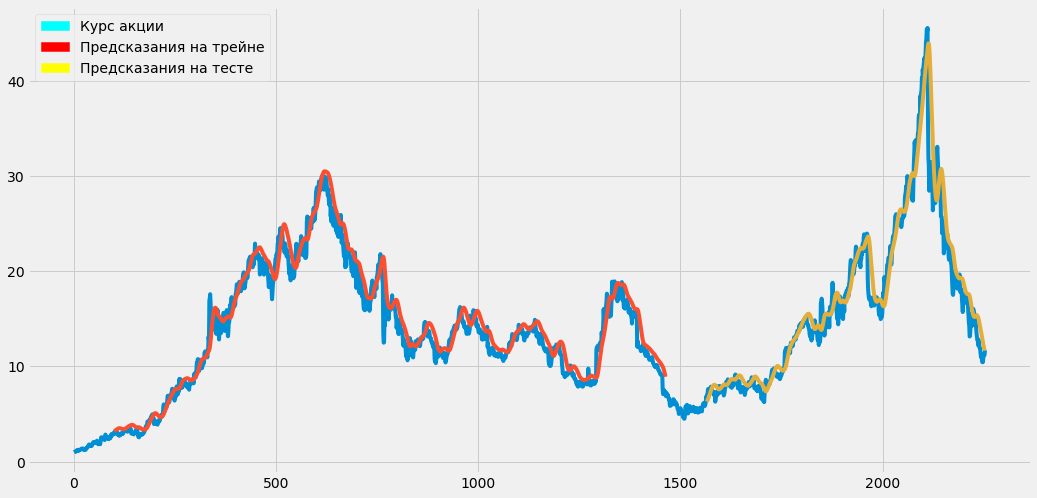

In [ ]:
# Построим график нашего обучения и предсказания модели на тестовых данных
### Plotting
#Shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back = 100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1,:] = test_predict
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='cyan', label='Курс акции')
red_patch = mpatches.Patch(color='red', label='Предсказания на трейне')
yellow_patch = mpatches.Patch(color='yellow', label='Предсказания на тесте')
plt.legend(handles=[blue_patch,red_patch,yellow_patch])
plt.show()


In [ ]:
# Попробуем сделать предсказание на 30 дней по следующей логике:
# Если time_step =100
# Берем последние 100 дней, по обученной модели предсказываем 101 день
# Добавляем его к данным, и сдвигаем эти 100 дней на одно значение
# Предсказываем следующий день, добавляем его к данным и сдвигаем 100 дней еще на одно значение
# Повторяем это 30 раз

In [ ]:
len(test_data)

789

In [ ]:
#Берем последние 100 дней
x_input = test_data[689:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# Получаем предсказания для 30 дней на основе последних 100 дней
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
      #print (temp input)
      x_input=np.array(temp_input[1:])
      print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape((1,n_steps, 1))
      #print (x_input)
      yhat = model.predict(x_input, verbose=0)
      print("{} day output {}".format(i,yhat))
      temp_input.extend(yhat[0].tolist())
      temp_input = temp_input[1:]
      #print(temp_input)
      lst_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1 , n_steps,1))
      yhat = model.predict(x_input, verbose=0)
      print(yhat[0])
      temp_input.extend(yhat[0].tolist())
      print(len(temp_input))
      lst_output.extend(yhat.tolist())
      i=i+1
print(lst_output)


[0.23484044]
101
1 day input [0.49458237 0.48403883 0.48314153 0.49637702 0.51701546 0.51252887
 0.49884467 0.50086365 0.46093273 0.45330548 0.47663591 0.4750656
 0.4750656  0.47035463 0.44590256 0.44006999 0.41830986 0.40170938
 0.37344368 0.3705274  0.38353859 0.4227965  0.41023398 0.40597168
 0.42616146 0.4279561  0.40507434 0.40305536 0.39520381 0.38757655
 0.3851089  0.3987931  0.39767142 0.41786119 0.41270159 0.41875854
 0.39430646 0.37703297 0.38196828 0.38466023 0.38196828 0.36020815
 0.34629966 0.33014783 0.35908651 0.3525809  0.35056192 0.35661886
 0.36716244 0.37277071 0.36985439 0.36559209 0.37456536 0.36828408
 0.36716244 0.35123492 0.3422617  0.32476387 0.30636874 0.29739551
 0.27249476 0.2740651  0.29178724 0.32386654 0.32655853 0.30906071
 0.30120914 0.29829283 0.30928504 0.33777506 0.3292505  0.32296922
 0.32655853 0.31422033 0.31489332 0.30547142 0.29403053 0.28012202
 0.27294344 0.26509185 0.26598917 0.25185632 0.25320231 0.26307286
 0.2473697  0.24579939 0.24512641 

In [ ]:
day_new=np.arange(1,101)
day_pred = np.arange(101,131)

In [ ]:
df3=df2.tolist()
df3.extend(lst_output)

In [ ]:
df3

[[0.0],
 [0.0004935270270315824],
 [0.0004935270270315824],
 [0.00022433070994462914],
 [0.0004935270270315824],
 [0.0021087102780193087],
 [0.0034098289305447525],
 [0.0034546945376870766],
 [0.0025125060907662394],
 [0.00291630190351317],
 [0.00542880799427941],
 [0.004374451518153254],
 [0.003095767006315475],
 [0.004553916620955556],
 [0.005451242134967074],
 [0.005451242134967074],
 [0.00522690875078944],
 [0.006595329825377881],
 [0.0069093917496071515],
 [0.008008613832875638],
 [0.008367544038480244],
 [0.008322675757104915],
 [0.008704040103397186],
 [0.006505595936860224],
 [0.0055634074899393905],
 [0.004800681471587846],
 [0.004845547078730174],
 [0.005159611677192456],
 [0.005451242134967074],
 [0.0052044772843347804],
 [0.007537518272298718],
 [0.010162189718037267],
 [0.009848127793807993],
 [0.010139758251582611],
 [0.012674695808803507],
 [0.012943894800123468],
 [0.013459855967842712],
 [0.017654842383193658],
 [0.017542677028221352],
 [0.01541153528374738],
 [0.01740

In [ ]:
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

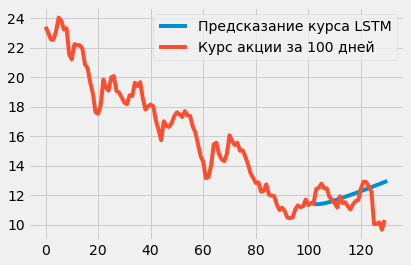

In [ ]:
# Рисуем график предсказаний на 30 дней для LSTM
#plt.plot(day_new,scaler.inverse_transform(df2[2154:]),label='Курс акции ')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Предсказание курса LSTM')
plt.plot(scaler.inverse_transform(df1[2154:]),label='Курс акции за 100 дней ')
plt.legend()
#plt.plot(df1[2154:])

#Линейная Регрессия

In [ ]:
# Построим  линейную регрессию:
#reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [ ]:
#Create and train  the Linear Regression  Model
lr = LinearRegression()
# Train the model
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
#Lets Do the prediction and sheck perfomance metrics
lr_train_predict = lr.predict(X_train)
lr_test_predict = lr.predict(X_test)

In [ ]:
type(lr_train_predict)

numpy.ndarray

In [ ]:
lr_train_predict = lr_train_predict.reshape(-1,1)
lr_test_predict = lr_test_predict.reshape(-1,1)


In [ ]:
lr_train_predict.shape

(1364, 1)

In [ ]:
y_train.shape

(1364,)

In [ ]:
## Transform back to the original form
lr_train_predict = scaler.inverse_transform(lr_train_predict)
lr_test_predict = scaler.inverse_transform(lr_test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,lr_train_predict))

14.96679462960134

In [ ]:
math.sqrt(mean_squared_error(y_test,lr_test_predict))

18.312529413515694

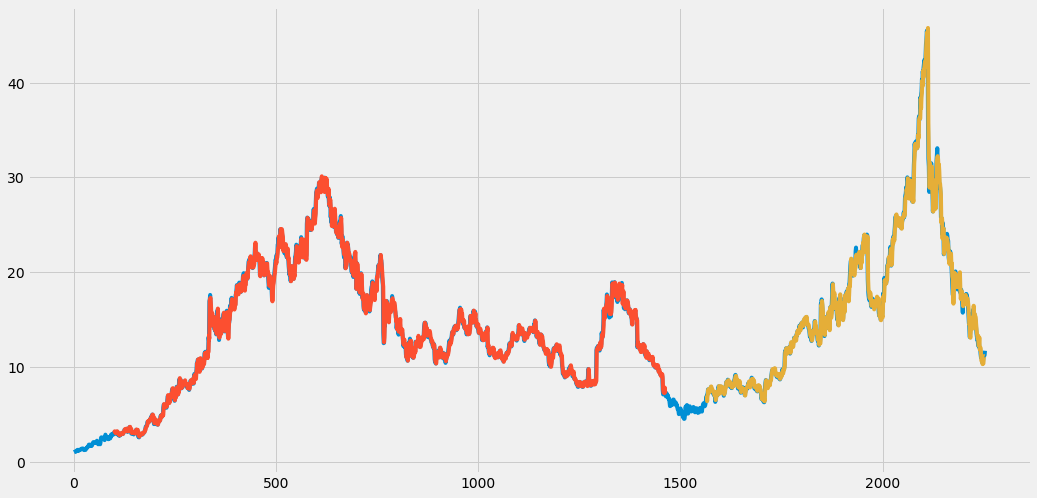

In [ ]:
### Plotting
#Shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back = 100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(lr_train_predict)+look_back, :] = lr_train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(lr_train_predict)+(look_back*2)+1:len(df2)-1,:] = lr_test_predict
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [ ]:
# Сделаем предсказание на 30 дней

In [ ]:
len(test_data)
x_input = test_data[689:]
x_input = test_data[689:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.5031069693683777,
 0.4945823702996859,
 0.4840388322807543,
 0.4831415308348399,
 0.4963770159792429,
 0.5170154626880128,
 0.5125288698829843,
 0.49884466983403186,
 0.5008636515719994,
 0.46093273171719557,
 0.4533054768821462,
 0.4766359135041156,
 0.4750656038829692,
 0.4750656038829692,
 0.4703546322318019,
 0.44590255810550744,
 0.4400699917377432,
 0.41830986473692017,
 0.4017093815040857,
 0.37344367996026645,
 0.37052739677638435,
 0.38353858865010476,
 0.4227965003296768,
 0.4102339805727776,
 0.4059716810384316,
 0.4261614556303802,
 0.4279561013099371,
 0.40507433680478916,
 0.40305535506682133,
 0.3952038069610895,
 0.38757655212604014,
 0.38510889827125117,
 0.39879309832020354,
 0.39767141802815037,
 0.4178611926200989,
 0.41270159163983844,
 0.4187585368537414,
 0.39430646272744685,
 0.37703297131938057,
 0.3819682790289584,
 0.3846602261544299,
 0.3819682790289584,
 0.36020815202813544,
 0.3462996587085004,
 0.33014782619862315,
 0.3590865145238103,
 0.3525808971930

In [ ]:
len(temp_input)

1

In [ ]:
#Получаем предсказаие на 30 дней
from numpy import array
lr_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
      #print (temp input)
      x_input=np.array(temp_input[1:])
      print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape((1,n_steps))
      #print (x_input)
      yhat = lr.predict(x_input)
      print("{} day output {}".format(i,yhat))
      temp_input.extend(yhat.tolist())
      temp_input = temp_input[1:]
      #print(temp_input)
      lr_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1 , n_steps))
      yhat = lr.predict(x_input)
      print(yhat[0])
      temp_input.extend(yhat.tolist())
      print(len(temp_input))
      lr_output.extend(yhat.tolist())
      i=i+1
print(lr_output)

0.24042402238305932
101
1 day input [0.49458237 0.48403883 0.48314153 0.49637702 0.51701546 0.51252887
 0.49884467 0.50086365 0.46093273 0.45330548 0.47663591 0.4750656
 0.4750656  0.47035463 0.44590256 0.44006999 0.41830986 0.40170938
 0.37344368 0.3705274  0.38353859 0.4227965  0.41023398 0.40597168
 0.42616146 0.4279561  0.40507434 0.40305536 0.39520381 0.38757655
 0.3851089  0.3987931  0.39767142 0.41786119 0.41270159 0.41875854
 0.39430646 0.37703297 0.38196828 0.38466023 0.38196828 0.36020815
 0.34629966 0.33014783 0.35908651 0.3525809  0.35056192 0.35661886
 0.36716244 0.37277071 0.36985439 0.36559209 0.37456536 0.36828408
 0.36716244 0.35123492 0.3422617  0.32476387 0.30636874 0.29739551
 0.27249476 0.2740651  0.29178724 0.32386654 0.32655853 0.30906071
 0.30120914 0.29829283 0.30928504 0.33777506 0.3292505  0.32296922
 0.32655853 0.31422033 0.31489332 0.30547142 0.29403053 0.28012202
 0.27294344 0.26509185 0.26598917 0.25185632 0.25320231 0.26307286
 0.2473697  0.24579939 0.24

In [ ]:
df3=df2.tolist()

In [ ]:
n = 3
m = 4
lr_output1 = []
for i in range(30):
    lr_output1.append([lr_output[i]] )
print(lr_output1)

[[0.24042402238305932], [0.242910764756338], [0.2467648875296073], [0.25305126723897703], [0.2521994901926185], [0.25459217127832634], [0.2574515251100543], [0.2557423719261936], [0.25598662073422945], [0.250799852757861], [0.24359974013027516], [0.24108206066522064], [0.23812904005251273], [0.23408524177331322], [0.23079316323358254], [0.2307511062939692], [0.23372687019377436], [0.23658153292093947], [0.23951098928502593], [0.23756064551744507], [0.2400637848258353], [0.23842505839562225], [0.23728480850836434], [0.23754587831193144], [0.23494003026950283], [0.23231548929161175], [0.23392553230988106], [0.2389846066892175], [0.24097967747526058], [0.24294258207194858]]


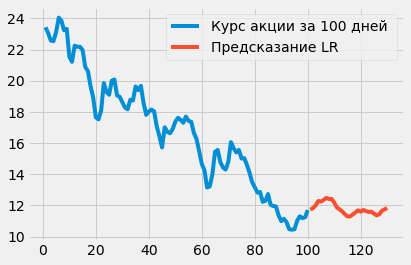

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df2[2154:]),label='Курс акции за 100 дней ')
plt.plot(day_pred,scaler.inverse_transform(lr_output1),label='Предсказание LR')
#plt.plot(day_pred,scaler.inverse_transform(lst_output))
#df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
#plt.plot(scaler.inverse_transform(df1[2154:]))
plt.legend()

#CatBoostRegressor

In [ ]:
#Так как CatBoost не требует нормализации вернемся к исходным данным
df1 = df.reset_index()['Close']
df3 = df1[:2254]
df3 = np.array(df3).reshape(-1,1)

training_size=int(len(df3)*0.65)
test_size=len(df3)-training_size
train_data,test_data=df3[0:training_size],df3[training_size:len(df3)]

In [ ]:
# Построим датасет X=t,t+1,t+2,t+3.... and Y=t+4
import numpy as np
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [ ]:
print(X_train)

[[ 1.00300002  1.02499998  1.02499998 ...  2.86100006  2.85700011
   2.98399997]
 [ 1.02499998  1.02499998  1.01300001 ...  2.85700011  2.98399997
   3.11199999]
 [ 1.02499998  1.01300001  1.02499998 ...  2.98399997  3.11199999
   3.03699994]
 ...
 [16.62000084 16.13999939 16.07999992 ...  7.1500001   7.1500001
   7.5       ]
 [16.13999939 16.07999992 16.47999954 ...  7.1500001   7.5
   7.30999994]
 [16.07999992 16.47999954 16.44000053 ...  7.5         7.30999994
   7.30000019]]


In [ ]:
print(y_train)

[3.11199999 3.03699994 2.9849999  ... 7.30999994 7.30000019 7.        ]


In [ ]:
print(X_train.shape), print(y_train.shape)

(1364, 100)
(1364,)


(None, None)

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.05,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.5216037	test: 0.3896732	best: 0.3896732 (0)	total: 78.9ms	remaining: 6m 34s
100:	learn: 0.0417955	test: 0.0758815	best: 0.0757481 (96)	total: 2.6s	remaining: 2m 5s
200:	learn: 0.0310691	test: 0.0726941	best: 0.0726941 (200)	total: 5.11s	remaining: 2m 1s
300:	learn: 0.0255494	test: 0.0712334	best: 0.0709609 (286)	total: 7.58s	remaining: 1m 58s
400:	learn: 0.0219894	test: 0.0704927	best: 0.0703662 (384)	total: 10.1s	remaining: 1m 56s
500:	learn: 0.0193187	test: 0.0705042	best: 0.0700998 (423)	total: 12.6s	remaining: 1m 53s
600:	learn: 0.0173093	test: 0.0710008	best: 0.0700998 (423)	total: 15.1s	remaining: 1m 50s
700:	learn: 0.0154005	test: 0.0714451	best: 0.0700998 (423)	total: 17.6s	remaining: 1m 48s
800:	learn: 0.0137439	test: 0.0717249	best: 0.0700998 (423)	total: 20.1s	remaining: 1m 45s
900:	learn: 0.0124222	test: 0.0717464	best: 0.0700998 (423)	total: 22.7s	remaining: 1m 43s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.07009984916
bestIteration = 

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
type(train_predict)

numpy.ndarray

In [ ]:
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

In [ ]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.33840021566882617

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

2.9709438177586858

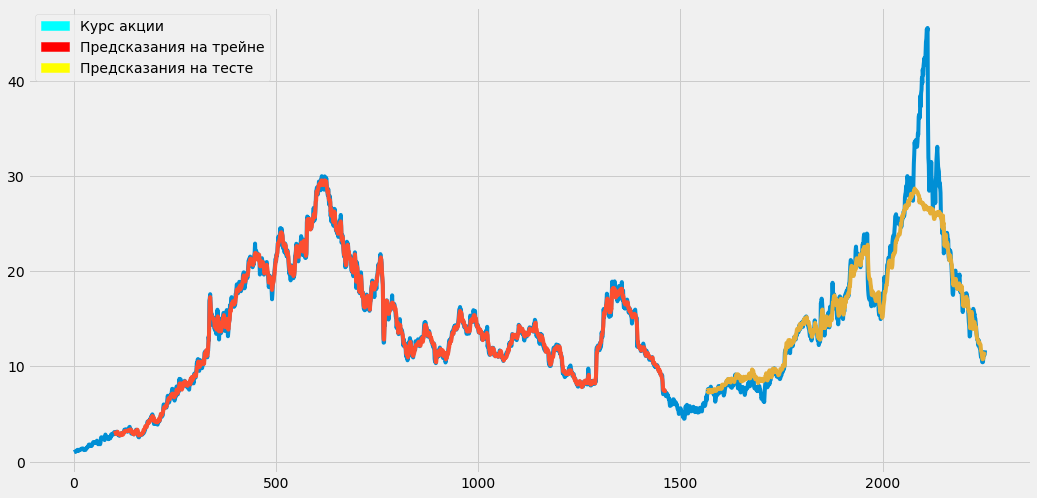

In [ ]:
### Plotting
#Shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back = 100
trainPredictPlot = numpy.empty_like(df3)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df3)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1,:] = test_predict
#plot baseline and predictions
plt.plot(df3)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='cyan', label='Курс акции')
red_patch = mpatches.Patch(color='red', label='Предсказания на трейне')
yellow_patch = mpatches.Patch(color='yellow', label='Предсказания на тесте')
plt.legend(handles=[blue_patch,red_patch,yellow_patch])
plt.show()

In [ ]:
# Сделаем предсказание на 30 дней

In [ ]:
len(test_data)
x_input = test_data[689:]
x_input = test_data[689:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
#temp_input

In [ ]:
#Получаем предсказаие на 30 дней
from numpy import array
cat_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
      #print (temp input)
      x_input=np.array(temp_input[1:])
      print("{} day input {}".format(i,x_input))
      x_input=x_input.reshape((1,n_steps))
      #print (x_input)
      yhat = model.predict(x_input)
      print("{} day output {}".format(i,yhat))
      temp_input.extend(yhat.tolist())
      temp_input = temp_input[1:]
      #print(temp_input)
      cat_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1 , n_steps))
      yhat = model.predict(x_input)
      print(yhat[0])
      temp_input.extend(yhat.tolist())
      print(len(temp_input))
      cat_output.extend(yhat.tolist())
      i=i+1
print(cat_output)

11.98657867542566
101
1 day input [23.04999924 22.57999992 22.54000092 23.12999916 24.04999924 23.85000038
 23.23999977 23.32999992 21.54999924 21.20999908 22.25       22.18000031
 22.18000031 21.96999931 20.87999916 20.62000084 19.64999962 18.90999985
 17.64999962 17.52000046 18.10000038 19.85000038 19.29000092 19.10000038
 20.         20.07999992 19.05999947 18.96999931 18.62000084 18.28000069
 18.17000008 18.78000069 18.72999954 19.62999916 19.39999962 19.67000008
 18.57999992 17.80999947 18.03000069 18.14999962 18.03000069 17.05999947
 16.44000053 15.72000027 17.01000023 16.71999931 16.62999916 16.89999962
 17.37000084 17.62000084 17.48999977 17.29999924 17.70000076 17.42000008
 17.37000084 16.65999985 16.26000023 15.47999954 14.65999985 14.26000023
 13.14999962 13.22000027 14.01000023 15.43999958 15.56000042 14.77999973
 14.43000031 14.30000019 14.78999996 16.05999947 15.68000031 15.39999962
 15.56000042 15.01000023 15.03999996 14.61999989 14.10999966 13.48999977
 13.17000008 12.8

In [ ]:
n = 3
m = 4
cat_output1 = []
for i in range(30):
    cat_output1.append([cat_output[i]] )
print(cat_output1)

[[11.98657867542566], [12.069815345186461], [12.30609290087592], [12.00687661906391], [11.851630280006376], [11.759893374477452], [11.766827587873811], [11.807086204660667], [11.851069703584765], [11.79929649390304], [11.734990593774082], [11.731770585668823], [11.820554923083469], [11.892837676464282], [11.864822555530257], [11.937438017930774], [11.994104868843396], [11.796292263499899], [11.892264774975537], [11.878365591573278], [11.878084053642855], [11.800983533579187], [11.898094583060525], [11.760378622562609], [11.710182684607751], [11.75504331541438], [11.824451501808305], [11.861519946363996], [11.89810702563641], [11.921873937304472]]


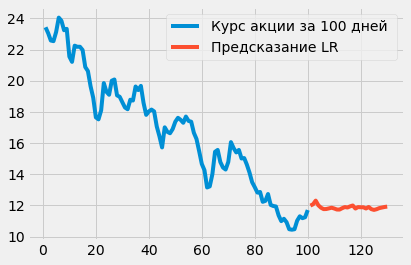

In [ ]:
plt.plot(day_new,df3[2154:],label='Курс акции за 100 дней ')
plt.plot(day_pred,cat_output1,label='Предсказание CatBoost')
#plt.plot(day_pred,scaler.inverse_transform(lst_output))
#df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
#plt.plot(scaler.inverse_transform(df1[2154:]))
plt.legend()

#График сравнения предсказаний LSTM+LR

In [ ]:
df1 = np.array(df1).reshape(-1,1)

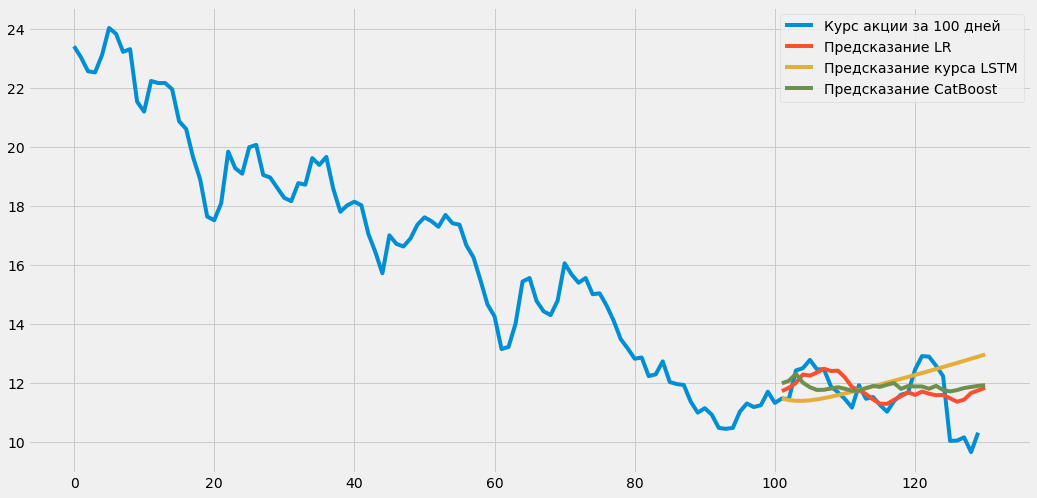

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df1[2154:],label='Курс акции за 100 дней ')
plt.plot(day_pred,scaler.inverse_transform(lr_output1),label='Предсказание LR')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Предсказание курса LSTM')
plt.plot(day_pred,cat_output1,label='Предсказание CatBoost')
plt.legend()